# Demo - Uncertain GP - Taylor Expansions

In [1]:
import sys
from pyprojroot import here
root = here(project_files=[".here"])
sys.path.append(str(here()))

# Jax settings
import jax
import jax.numpy as np
import objax
import numpyro
import numpyro.distributions as dist

# Gaussian process settings
from jaxkern.data.regression import simple, near_square_wave
from jaxkern.gp.exact import ExactGP
from jaxkern.kernels.stationary import RBF, RationalQuadratic
from jaxkern.gp.mean import LinearMean, ZeroMean
from jaxkern.gp.losses import negative_log_likelihood
from jaxkern.gp.optimize import optimize_model
from jaxkern.gp.utils import confidence_intervals
from jaxkern.gp.uncertain.linear import TaylorFirstOrder, TaylorSecondOrder

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Data

In [2]:
# X, y, Xtest, ytest = simple(30, 400, 0.0, 0.05)
ntrain = 60
ntest = 1_000
input_cov = 0.3

output_cov = 0.05
X, y, Xtest, ytest = near_square_wave(ntrain, ntest, input_cov, output_cov)

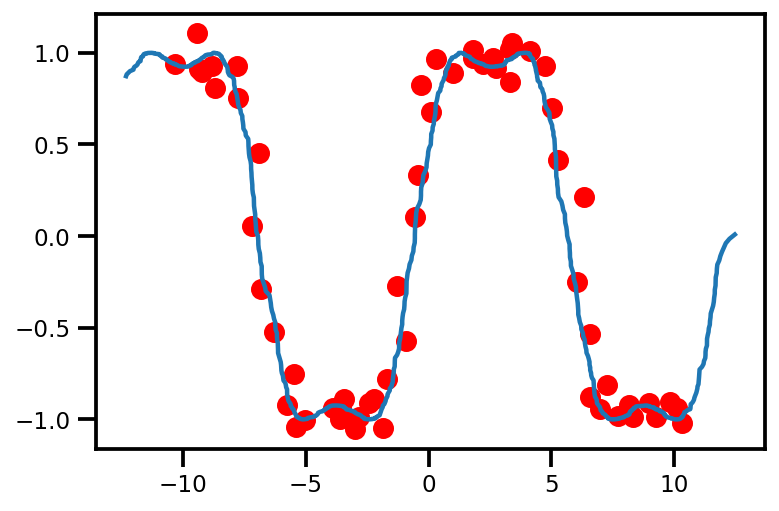

In [3]:
plt.scatter(X, y, color='red')
plt.plot(Xtest, ytest)

## Model

In [4]:
# initialize kernel
# kernel = RBF(length_scale=0.01, variance=1.0)
kernel = RationalQuadratic()


# initialize mean function
# mean = LinearMean(input_dim=1, output_dim=1)
mean = ZeroMean(input_dim=1)

# initialize function
gp_model = ExactGP(mean=mean, kernel=kernel)

# inspect variables
for ikey, val in gp_model.vars().items():
    print(ikey, val.value)

(ExactGP).kernel(RationalQuadratic).variance [1.]
(ExactGP).kernel(RationalQuadratic).length_scale [1.]
(ExactGP).kernel(RationalQuadratic).alpha [1.]
(ExactGP).noise [0.1]


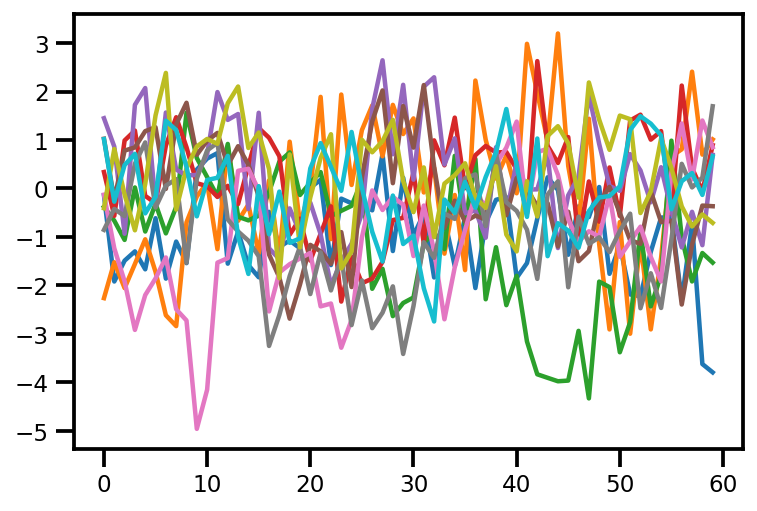

In [5]:
# generate random samples
dist = gp_model.forward(X)

seed = jax.random.PRNGKey(123)
y_samples = dist.sample((10,), seed=seed)

# plot
plt.plot(y_samples.T);

### Training

In [6]:
jitted = True
n_epochs = 1_000
lr = 0.01
model, losses = optimize_model(
    model=gp_model,
    loss_f=negative_log_likelihood,
    X=X, y=y,
    lr=lr,
    opt=objax.optimizer.Adam,
    n_epochs=n_epochs,
    jitted=jitted
)

100%|██████████| 1000/1000 [00:05<00:00, 199.17it/s, Loss=8.31]


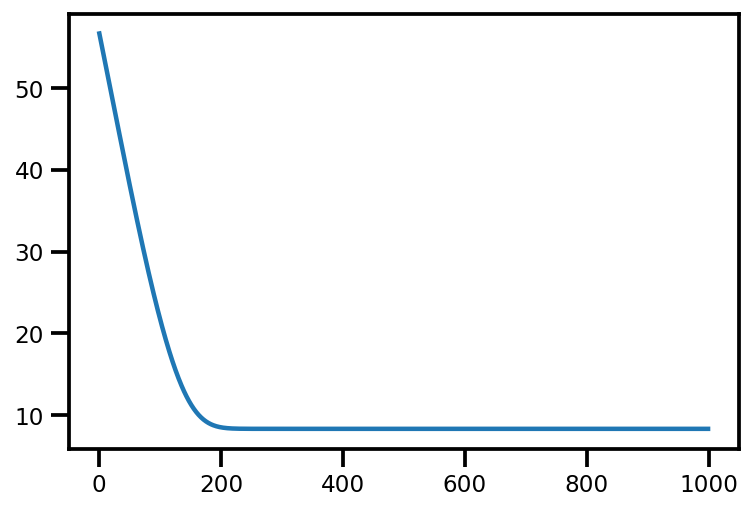

In [7]:
plt.plot(losses)

In [8]:
for ikey, val in model.vars().items():
    print(ikey, val.value, jax.nn.softplus(val.value), type(val.value), val.value.shape)

(ExactGP).kernel(RationalQuadratic).variance [1.] [1.3132617] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).kernel(RationalQuadratic).length_scale [2.3949027] [2.482164] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).kernel(RationalQuadratic).alpha [0.74324644] [1.1322892] <class 'jax.interpreters.xla.DeviceArray'> (1,)
(ExactGP).noise [-1.6141466] [0.18153831] <class 'jax.interpreters.xla.DeviceArray'> (1,)


In [9]:
model.cache_factorizations(X, y)

mu, cov = model.predict_f(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

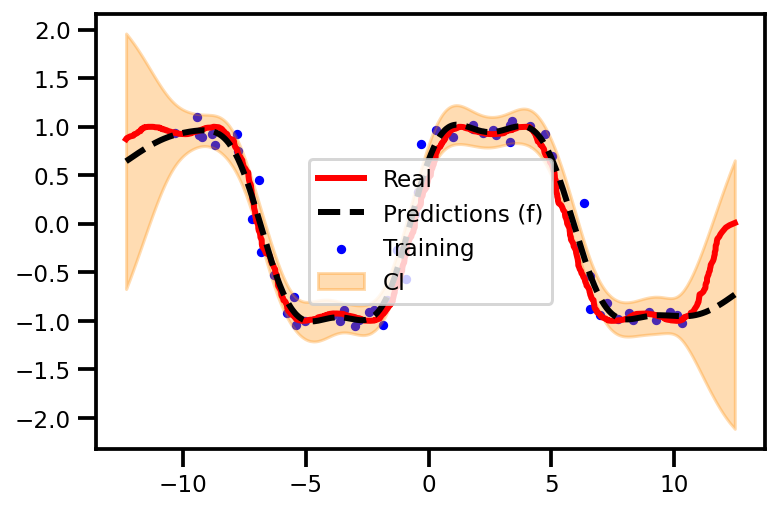

In [10]:
# plot
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="--", label='Predictions (f)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

In [11]:
mu, cov = model.predict_y(Xtest)
y_var = np.diagonal(cov)
lb, ub = confidence_intervals(mu, y_var, 96)

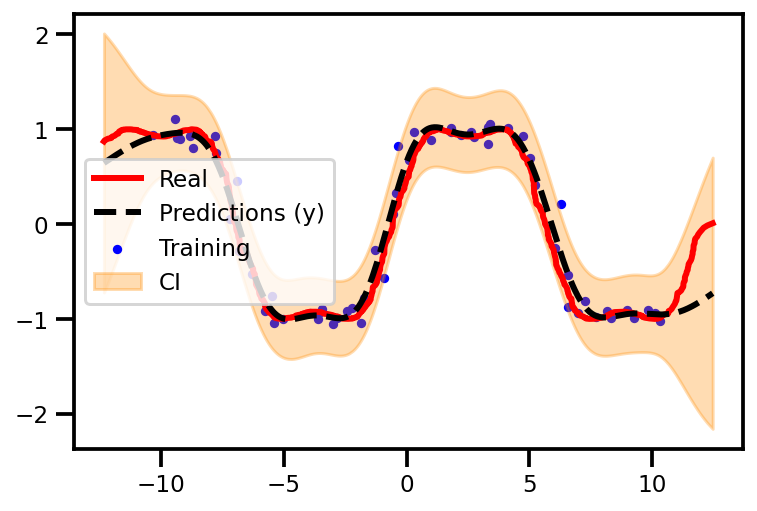

In [12]:
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

## Taylor Expansion

In [13]:
# initialize linearization transformation
lin_transform = TaylorFirstOrder(model, noise=False)

In [14]:
Xcov = np.tile(np.diag(np.array([input_cov])), (ntest, 1, 1))
mu_o1, var_o1 = lin_transform.forward(Xtest, Xcov)
mu_o1.shape, var_o1.shape

((1000,), (1000,))

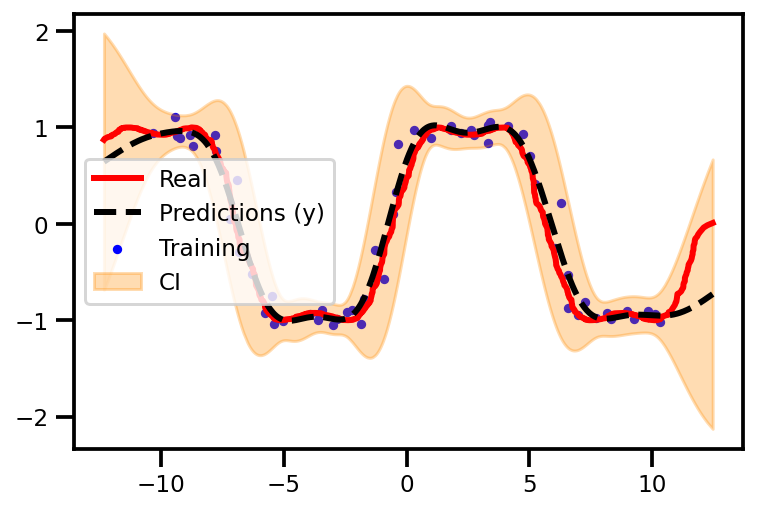

In [15]:
lb, ub = confidence_intervals(mu_o1, var_o1, 96)
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu_o1, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

In [16]:
# initialize linearization transformation
lin_transform = TaylorFirstOrder(model, noise=True)

mu_o1, var_o1 = lin_transform.forward(Xtest, Xcov)
mu_o1.shape, var_o1.shape

((1000,), (1000,))

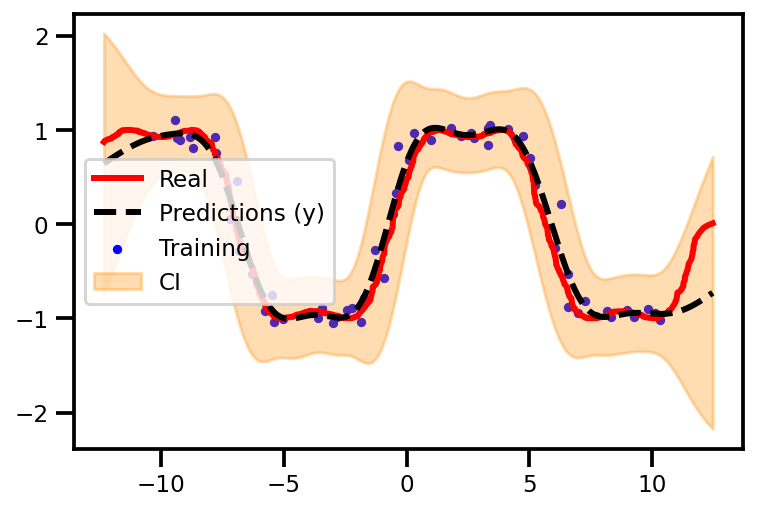

In [17]:
lb, ub = confidence_intervals(mu_o1, var_o1, 96)
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu_o1, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

### 2nd Order

In [18]:
# initialize linearization transformation
lin_transform = TaylorSecondOrder(model, noise=False)

mu_o2, var_o2 = lin_transform.forward(Xtest, Xcov)
mu_o2.shape, var_o2.shape

((1000,), (1000,))

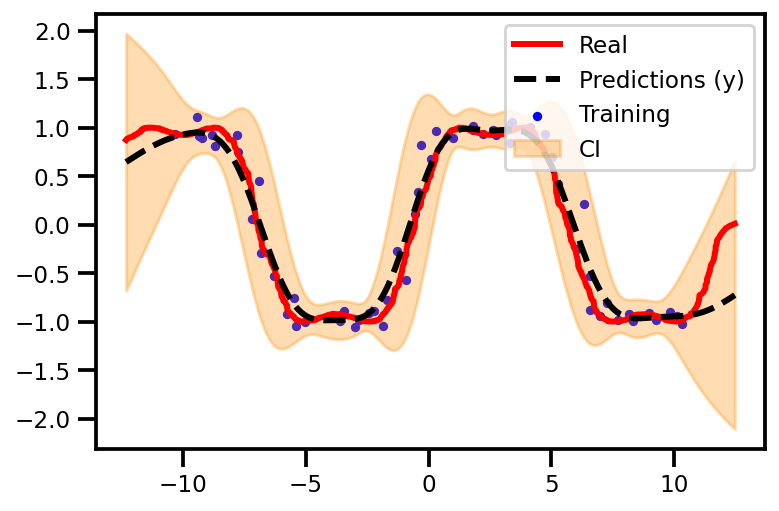

In [19]:
lb, ub = confidence_intervals(mu_o2, var_o2, 96)
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu_o2, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

In [20]:
# initialize linearization transformation
lin_transform = TaylorSecondOrder(model, noise=True)

mu_o2, var_o2 = lin_transform.forward(Xtest, Xcov)
mu_o2.shape, var_o2.shape

((1000,), (1000,))

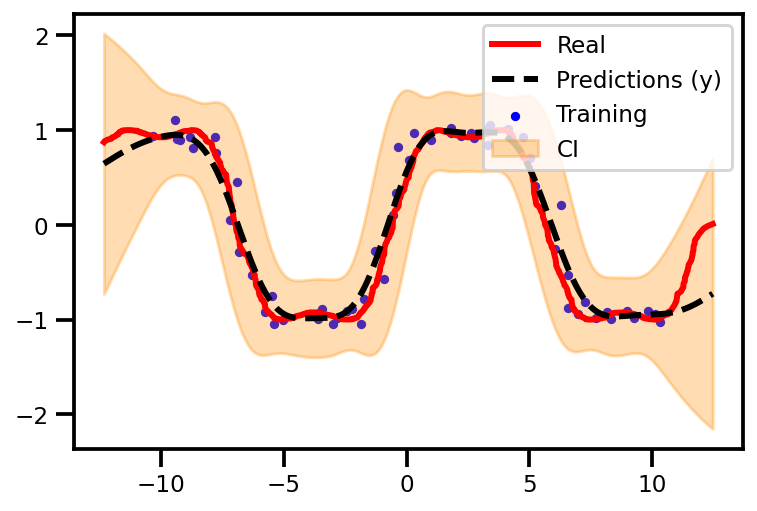

In [21]:
lb, ub = confidence_intervals(mu_o2, var_o2, 96)
plt.figure()
plt.scatter(X, y, label='Training', color='blue', s=10)
plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu_o2, linestyle="--", label='Predictions (y)', color='black', linewidth=3)
plt.fill_between(Xtest.squeeze(), lb, ub, label='CI', color='darkorange', alpha=0.3)

plt.legend()

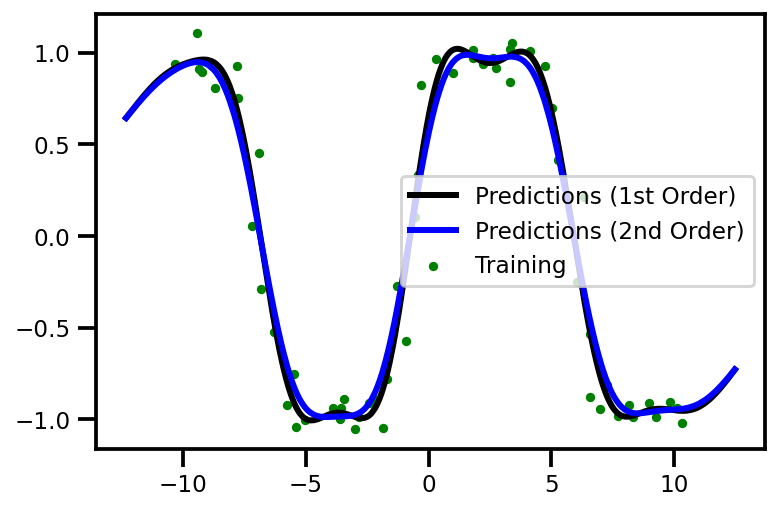

In [22]:
plt.figure()
plt.scatter(X, y, label='Training', color='green', s=10)
# plt.plot(Xtest, ytest, label='Real', color='red', linewidth=3)
plt.plot(Xtest, mu_o1, linestyle="-", label='Predictions (1st Order)', color='black', linewidth=3)
plt.plot(Xtest, mu_o2, linestyle="-", label='Predictions (2nd Order)', color='blue', linewidth=3)
plt.legend()